In [1]:
import pandas as pd
import numpy as np
import os
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import pearsonr
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Seed
SEED = 2333
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.set_device(1)
    torch.cuda.manual_seed(SEED)

In [3]:
# Model parameters
NUMBER_EPOCHS = 10
LEARNING_RATE = 1E-4
WEIGHT_DECAY = 1E-4
BATCH_SIZE = 1
NUM_CLASSES = 1

# GCN parameters
GCN_FEATURE_DIM = 30
GCN_HIDDEN_DIM = 256
GCN_OUTPUT_DIM = 64  
# Attention parameters
DENSE_DIM = 16
ATTENTION_HEADS = 4

In [4]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -0.5).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_mat_inv = np.diag(r_inv)
    result = r_mat_inv @ mx @ r_mat_inv
    return result

In [5]:
def load_features(label_number, mean, std):

    
    # len(sequence) * 23
    blosum_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN\\Blosum features_yeast\\' + str(label_number) + '.npy')
    
    # len(sequence) * 30
    a7_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN\\7A features_yeast\\' + str(label_number) + '.npy')
    
    
    # len(sequence) * 33
    coord_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN\\Acarbon_coordinates_centered_yeast\\' + str(label_number) + '.npy')
 

    #print(label_number)
    feature_matrix = np.concatenate([blosum_matrix,a7_matrix,coord_matrix], axis=1)
    feature_matrix = (feature_matrix - mean) / std
    part1 = feature_matrix[:,0:20]
    part2 = feature_matrix[:,23:]
    # len(sequence) * 30
    feature_matrix = np.concatenate([part1,part2],axis=1)
    return feature_matrix

In [6]:
def load_values():
    mean = np.load("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\GCN\\mean_matrix.npy")
    std = np.load("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\GCN\\std_matrix.npy")
    return mean, std

In [7]:
def load_graph(label_number): ###################################################################################1
    matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN\\Contact maps_12A_yeast\\' + str(label_number) + '.npy').astype(np.float32)
    edge_matrix = normalize(matrix)
    return edge_matrix

In [8]:
class ProDataset(Dataset):

    def __init__(self, dataframe):
        self.label = dataframe['Number'].values
        self.solubility = dataframe['solubility'].values
        self.mean, self.std = load_values()

    def __getitem__(self, index):
        sequence_label = self.label[index]
        solubility = self.solubility[index]
        # L * 30
        sequence_feature = load_features(sequence_label, self.mean, self.std)
        # L * L
        sequence_graph = load_graph(sequence_label)
        
        return sequence_label, solubility, sequence_feature, sequence_graph

    def __len__(self):
        return len(self.solubility)

In [9]:
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = input @ self.weight    # X * W
        output = adj @ support           # A * X * W
        if self.bias is not None:        # A * X * W + b
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [10]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(GCN_FEATURE_DIM, GCN_HIDDEN_DIM)
        self.ln1 = nn.LayerNorm(GCN_HIDDEN_DIM)
        self.gc2 = GraphConvolution(GCN_HIDDEN_DIM, GCN_OUTPUT_DIM)
        self.ln2 = nn.LayerNorm(GCN_OUTPUT_DIM)
        self.relu1 = nn.LeakyReLU(0.2,inplace=True)
        self.relu2 = nn.LeakyReLU(0.2,inplace=True)

    def forward(self, x, adj):  			# x.shape = (seq_len, GCN_FEATURE_DIM); adj.shape = (seq_len, seq_len)
        x = self.gc1(x, adj)  				# x.shape = (seq_len, GCN_HIDDEN_DIM)
        x = self.relu1(self.ln1(x))
        x = self.gc2(x, adj)
        output = self.relu2(self.ln2(x))	# output.shape = (seq_len, GCN_OUTPUT_DIM)
        return output

In [11]:
class Attention(nn.Module):
    def __init__(self, input_dim, dense_dim, n_heads):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        self.dense_dim = dense_dim
        self.n_heads = n_heads
        self.fc1 = nn.Linear(self.input_dim, self.dense_dim)
        self.fc2 = nn.Linear(self.dense_dim, self.n_heads)

    def softmax(self, input, axis=1):
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size) - 1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = torch.softmax(input_2d, dim=1)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size) - 1)

    def forward(self, input):  				# input.shape = (1, seq_len, input_dim)
        x = torch.tanh(self.fc1(input))  	# x.shape = (1, seq_len, dense_dim)
        x = self.fc2(x)  					# x.shape = (1, seq_len, attention_hops)
        x = self.softmax(x, 1)
        attention = x.transpose(1, 2)  		# attention.shape = (1, attention_hops, seq_len)
        return attention

In [12]:
class GCN_model(nn.Module):
    def __init__(self):
        super(GCN_model, self).__init__()

        self.gcn = GCN()
        self.attention = Attention(GCN_OUTPUT_DIM, DENSE_DIM, ATTENTION_HEADS)
        self.fc_final = nn.Linear(GCN_OUTPUT_DIM, NUM_CLASSES)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    def forward(self, x, adj):  											# x.shape = (seq_len, FEATURE_DIM); adj.shape = (seq_len, seq_len)
        x = x.float()
        x = self.gcn(x, adj)  												# x.shape = (seq_len, GAT_OUTPUT_DIM)

        x = x.unsqueeze(0).float()  										# x.shape = (1, seq_len, GAT_OUTPUT_DIM)
        att = self.attention(x)  											# att.shape = (1, ATTENTION_HEADS, seq_len)
        node_feature_embedding = att @ x 									# output.shape = (1, ATTENTION_HEADS, GAT_OUTPUT_DIM)
        node_feature_embedding_avg = torch.sum(node_feature_embedding,
                                               1) / self.attention.n_heads  # node_feature_embedding_avg.shape = (1, GAT_OUTPUT_DIM)
        output = torch.sigmoid(self.fc_final(node_feature_embedding_avg))  	# output.shape = (1, NUM_CLASSES)
        output2 = self.fc_final(node_feature_embedding_avg)


        return output.squeeze(0)

In [13]:
GCN_model = GCN_model()

In [14]:


GCN_model_directory="C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\GCN\\model.pkl"
GCN_model.load_state_dict(torch.load(GCN_model_directory))

<All keys matched successfully>

In [15]:
train_dataframe = pd.read_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN\\Yeast_solubility_testing.csv")

In [16]:
list_label=[]
list_pred=[]
list_solubility=[]
def test_models(all_dataframe):
    print("split_seed: ", SEED)
    sequence_label = all_dataframe['Number'].values
    solubility = all_dataframe['solubility'].values
    data_loader1 = DataLoader(dataset=ProDataset(all_dataframe), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    

    for data in tqdm(data_loader1):
        with torch.no_grad():
            sequence_label, solubility, sequence_features, sequence_graphs = data
            sequence_features = torch.squeeze(sequence_features)
            sequence_graphs = torch.squeeze(sequence_graphs)
            

            if torch.cuda.is_available():
                features = Variable(sequence_features.cuda())
                graphs = Variable(sequence_graphs.cuda())
                y_true = Variable(solubility.cuda())
               
            else:
                features = Variable(sequence_features)
                graphs = Variable(sequence_graphs)
                y_true = Variable(solubility)
            

                                    
            y_pred_GCN = GCN_model(features,graphs)
            y_true = y_true.float()

            y_pred_GCN = y_pred_GCN.cpu().detach().numpy().tolist()
            list_pred.append(y_pred_GCN)
            list_label.append(sequence_label)
            list_solubility.append(solubility)
                    
    

In [17]:
test_models(train_dataframe)

split_seed:  2333


100%|██████████| 108/108 [00:04<00:00, 23.37it/s]


In [18]:
list_label_real=[]
list_pred_real=[]
list_solubility_real=[]


for i in range(0,len(list_label)):
    A=list_label[i].tolist()
    list_label_real.append(A[0])
    
for j in range (0,len(list_pred)):
    B=list_pred[j]
    list_pred_real.append(B[0])
    
for k in range(0,len(list_solubility)):
    C=list_solubility[k].tolist()
    list_solubility_real.append(C[0])

Text(0, 0.5, 'Experimental solubility')

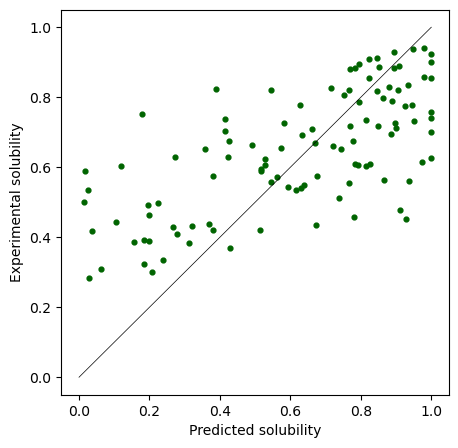

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(list_solubility_real, list_pred_real,s=12, color='darkgreen')
plt.plot([0, 1], [0, 1],color='black',linewidth=0.5)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Predicted solubility')
plt.ylabel('Experimental solubility')


In [29]:
columns=['label','prediction','solubility']
df = pd.DataFrame(list(zip(list_label_real, list_pred_real,list_solubility_real)))
df.columns = columns
print(df)

     label  prediction  solubility
0       42    0.535816       0.617
1       38    0.560550       0.937
2       73    0.817141       0.846
3       81    0.421165       0.380
4       12    0.604260       0.120
..     ...         ...         ...
103     43    0.443575       0.106
104     91    0.821120       0.546
105     98    0.574133       0.379
106     93    0.393328       0.185
107      0    0.417795       0.038

[108 rows x 3 columns]


In [31]:
df.to_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Yeast_data\\GCN_result.csv")

